# Predicting Burned Areas on Landsat 5 Images using Machine Learning in Python


**This post provides a comprehensive guide to predicting burned areas on Landsat 5 images using machine learning in Python. It covers all the steps involved in the process, from image acquisition and data preparation to model training, evaluation, and prediction.**

 

## Introduction


Forest and Agricultural fires are a major threat to the environment and human life. They can cause severe damage to the environment, property, and human life. In 2019, the Amazon rainforest wildfires burned more than 906,000 hectares of forest. In 2020, the Australian wildfires burned more than 18 million hectares of land. In 2021, the California wildfires burned more than 1.6 million hectares of land.

The ability to predict the burned areas on satellite images can help us to better understand the impact of wildfires on the environment and human life. It can also help us to better manage the wildfires and reduce their impact on the environment and human life.

In this notebook, we will use machine learning to predict the burned areas on Landsat 5 images. We will use python  to prepare the data, train the model, and evaluate the model.Specifically, we will use Random Forest algorithm to predict the burned area on the image using scikit-learn. We will follow the study area from my co-authored paper with my colleagues at Ashoka University on comparing methods to detect burned area in Central India. The paper is published in Frontiers in Forests and Global Change and can be accessed [here](https://www.frontiersin.org/articles/10.3389/ffgc.2022.933807/full). 


The post is divided into 5 parts: 1). Image acquisition 2) Data preparation, 3) Model training, 4) Model evaluation and 5) Prediction on the image
 

### Landsat 5

Landsat is a joint programme of the USGS and NASA. Landsat satellites image the entire Earth's surface at a 30-meter resolution about once every two weeks. The Latest instalment on the series is Landst 9 which became operational in 2021. We would be using image from Landsat 5 which has been running from 1984 to 2013, thus providing us accessibly and capability to inquire about burned area historically.  The USGS produces data in 3 categories for each satellite (Tier 1, Tier 2 and R).  We will be using  landsat 5 collection 2:level 2:tier 1. Tier 1 (T1) data meets geometric and radiometric quality requirements. 


This dataset contains atmospherically corrected surface reflectance and land surface temperature derived from the data produced by the Landsat TM sensor. These images contain 4 visible and near-infrared (VNIR) bands and 2 short-wave infrared (SWIR) bands processed to orthorectified surface reflectance, and one thermal infrared (TIR) band processed to orthorectified surface temperature. We will use all the bands except the thermal bands since the thermal band has different resolution (100m) than others.

There are a bunch of ways to download the data:

- [Google Earth Engine](https://developers.google.com/earth-engine/datasets)

- [USGS Explorer](https://earthexplorer.usgs.gov/)

- [AWS](https://registry.opendata.aws/usgs-landsat/)

- [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/catalog) 

In this post, we will use planetary computer's open access data catalogue to download the data. The data is stored in cloud optimised geotiff format which makes it easy to access and process.




## Importing Libraries

We start by importing the necessary libraries.


In [2]:
#  pystac for STAC queries
import pystac
import pystac_client


#  to access data on the Planetary Computer platform
import planetary_computer

# for reading raster data
import rasterio

# for reading and manipulating vector data
import geopandas as gpd


# y for working with arrays
import numpy as np

#  for machine learning algorithms
import sklearn

## Downlaoding the Image from Planetary computer

![image1](./pc1.webp) 


Planetary Computer is Microsoft's equivalent of Google Earth Engine (GEE), but with some key differences. Unlike GEE, which is primarily based on a JavaScript platform, Planetary Computer offers Python (CPU and GPU) and R notebooks for computation. This provides users with the flexibility to work in their preferred programming language for geospatial analysis.

What sets Planetary Computer apart is its public data repository and open access API, which supports querying data using SpatioTemporal Asset Catalogs (STAC). STAC is a specification that defines a standardised format for describing geospatial data. It enables machine-readable structures for efficient data querying and downloading from the repository.

If you want to learn more about STAC, you can check out their official documentation at [STAC](https://chat.openai.com/c/788b55fc-5088-427c-bdcf-a5aa201c84ea#:~:text=Planetary%20Computer%20is%20Microsoft%27s,tasks%20without%20unnecessary%20complexities.).

In our specific case, accessing the desired image from Planetary Computer is quite straightforward. Simply specify the common access point, collection, and image ID, and you can retrieve the image for further analysis and processing. This simplified data retrieval process allows us to focus on our analysis tasks without unnecessary complexities.

In [2]:


# specify the api access point
api_url = 'https://planetarycomputer.microsoft.com/api/stac/v1/'

#image collection
collection = 'landsat-c2-l2'

#image ID
image_id = 'LT05_L2SP_145044_20100428_02_T1'

# access the catalogue and get our image assets
catalogue = pystac_client.Client.open(api_url)
collection = catalogue.get_collection(collection)
item = collection.get_item(image_id)
item = planetary_computer.sign(item)

#call the assets
assets = item.assets


# print the bands
for keys, asset in assets.items():
    print(f"{keys}: {asset.title}")

qa: Surface Temperature Quality Assessment Band
ang: Angle Coefficients File
red: Red Band
blue: Blue Band
drad: Downwelled Radiance Band
emis: Emissivity Band
emsd: Emissivity Standard Deviation Band
lwir: Surface Temperature Band
trad: Thermal Radiance Band
urad: Upwelled Radiance Band
atran: Atmospheric Transmittance Band
cdist: Cloud Distance Band
green: Green Band
nir08: Near Infrared Band 0.8
swir16: Short-wave Infrared Band 1.6
swir22: Short-wave Infrared Band 2.2
mtl.txt: Product Metadata File (txt)
mtl.xml: Product Metadata File (xml)
cloud_qa: Cloud Quality Assessment Band
mtl.json: Product Metadata File (json)
qa_pixel: Pixel Quality Assessment Band
qa_radsat: Radiometric Saturation and Dropped Pixel Quality Assessment Band
atmos_opacity: Atmospheric Opacity Band
tilejson: TileJSON with default rendering
rendered_preview: Rendered preview


To conduct our analysis, we carefully choose the bands we need from the provided list. We specify these bands as a list of strings, using them to access the download link for each specific band. Leveraging the power of the rasterio library, we read in the bands from their respective links. Then, employing the versatility of numpy, we cleverly stack the bands together, resulting in a cohesive and comprehensive single image for further analysis.

In [3]:
# list of bands we need
bands_list = [ 'red', 'green','blue', 'nir08', 'swir16', 'swir22' ]


# extract the urls
band_urls = [assets[band].href for band in bands_list] 

#we use the urls to read in the image
raster_pc = [rasterio.open(url) for url in band_urls]
bands_pc = [band.read(1) for band in raster_pc]

# we stack the individual bands
# we specify as xis 0 since the the individual raster shape is (bands, row, col) and we want to add the rasteers through the same axis
l5_pc = np.stack(bands_pc, axis = 0)

#check the shape of stacked raster
l5_pc.shape

(6, 6901, 7811)

In [4]:
#check the data range
(l5_pc.min(), l5_pc.max())

(0, 65535)

We observe that the image has 6 bands, and its shape is 6 x 6901 x 7811. Additionally, we identify the presence of nodata values, which are currently represented by 0. To handle this, we will replace these nodata values with NaN (Not-a-Number), ensuring they do not affect our subsequent calculations.

### Scaling

The data ranges from 0 to 65535, as it is stored in a 16-bit format. To convert this data to surface reflectance, which ranges from 0 to 1, we will use a scale and offset factor. Scaling the data to surface reflectance offers several benefits:

**Easier Interpretation**: Surface reflectance values are more intuitive and easier to interpret compared to raw DN (Digital Number) values.

**Improved Machine Learning**: Machine learning algorithms often perform better with scaled data. By converting to surface reflectance, we enhance the compatibility and effectiveness of these algorithms.

**Enhanced visualisation**: Surface reflectance values are visually appealing and easier to visualise, aiding in data exploration and result communication.

By performing the scaling process, we ensure that the data is appropriately transformed and ready for further analysis.


In [5]:
# create a mask for all the nodata using the first band
mask = np.ma.masked_equal(l5_pc,raster_pc[0].nodata)


# # Create an empty numpy array to store the scaled values
l5_scaled = np.zeros(shape= l5_pc.shape, dtype= rasterio.float64)


mult = 0.0000275 # scale
add = -0.2 # offset


# now that we have same mask for evey band, we can directly scale
# we use np.where to restrict operations on non-masked elements
#at the same time we convert the zero's no NaN since anyway the scaled data will be in float64

l5_scaled =  np.where(~mask.mask,l5_pc* mult + add, np.nan)

# check the data range
print((np.nanmin(l5_scaled), np.nanmax(l5_scaled)))

(-0.0774325, 1.6022125)


In [6]:
# check the size after
# size will increase since the dtype float64

print(f"data type and the size before conversion is: {l5_pc.dtype}, {round(l5_pc.nbytes/1024**3,2)} GB")
print(f"data type and the size after conversion is: {l5_scaled.dtype}, {round(l5_scaled.nbytes/1024**3,2)} GB")      



data type and the size before conversion is: uint16, 0.6 GB
data type and the size after conversion is: float64, 2.41 GB


We notice a significant increase in the image size from 0.6 GB to 2.41 GB. This enlargement is a consequence of converting the data from a 16-bit integer to a 64-bit float format, providing us with more precise decimal points.

Now that we have our image stacked, scaled, and the nodata values replaced with NaN, it's time to save it for future use. To accomplish this task, we turn to the powerful rasterio library, which offers efficient functions specifically designed for handling raster data. With rasterio, we can effortlessly save our processed image to our preferred device, ensuring easy accessibility for subsequent analysis and visualisation.

Using rasterio, we can save the processed image to our desired location, ensuring that it is readily available for further analysis and visualisation when needed.

In [7]:

output_l5 = './data/145044_20090425_ms_pc.tif'
# we change the data to float64 since we scaled it

profile = raster_pc[1].profile
profile.update({
    'count':6,
    'dtype': rasterio.float64,
    'nodata': np.nan
})

# keep in mind - compression is `deflate`

with rasterio.open(output_l5, 'w', **profile) as dst:
    dst.write(l5_scaled)

## Read the data

To begin, we read the training points from a geojson file using the geopandas library. These points were manually annotated by visually inspecting the image. Our annotation process involved creating a combination of NIR, Red, and Green bands, which allows us to observe burned areas as purple in color. Admittedly, identifying pixel classes at a 30m resolution can be challenging. However, with some remote sensing knowledge and training, it becomes feasible.

I would like to express my gratitude to my supervisor, Dr. Meghna, whose decades of experience in studying the area and expertise in fires have been invaluable. Her knowledge has guided us throughout this project. I would also like to thank my co-RA, Wajida, who has been a real saviour in the annotation process. She has an exceptional talent for interpreting raw satellite images, and her contributions have been truly outstanding. A big shout-out to her!

In our research paper, we had approximately 12 classes, including forest, burned forest, agriculture, burned agriculture, fallen leaves, agriculture with no crop, water, shadows, and more. The aim of having these diverse classes was to differentiate between burned areas in forests and agriculture while also assessing potential confounding factors related to fire. This approach helps us build a more robust model. However, for the sake of simplicity in our current analysis, we have reclassified them into just two classes.

### Vector Data

For handling the vector data, we leverage the geopandas library. By reading the geojson file, we can observe that the data is structured in geojson format, consisting of two columns: geometry and class. The geometry column contains the coordinates of the points, while the class column denotes the corresponding class for each point. Notably, we observe that there are two classes: Burned and Unburned.








In [3]:
training_path = './data/BA_training_pixels_2.geojson'
training_pixels = gpd.read_file(training_path)
training_pixels.head()

,class,land_class,geometry
0,13.0,Burned,POINT (739290.000 2659620.000)
1,1.0,Unburned,POINT (730050.000 2650620.000)
2,13.0,Burned,POINT (762240.000 2649120.000)
3,5.0,Burned,POINT (798120.000 2648130.000)
4,4.0,Unburned,POINT (781020.000 2646150.000)


Let's take a look at the distribution of the classes.

In [4]:
training_pixels['land_class'].value_counts()

Unburned    447
Burned      253
Name: land_class, dtype: int64

Create  a dictionary with class labels for later use.

In [5]:
classes = np.unique(training_pixels['land_class'])
class_dict = dict(zip(list(classes), range(len(classes))))

class_dict

{'Burned': 0, 'Unburned': 1}

### Raster data

We read the downloaded image using rasterio and check for the projection match with the vector data. It is important to have both the training points and the raster image to same projection since we'll overlay the points on the raster to extract the band values to build the training data.

In [6]:

raster_path = './data/145044_20090425_ms_pc.tif'
raster = rasterio.open(raster_path)
bands = raster.read()

# check if the both files are in same crs
assert training_pixels.crs == raster.crs , "crs are not the same"
    

## Visualise the data

We visualise the data by overlaying the points on top of the raster for a visual inspection. Taking a closer look at the histogram, we notice a significant number of outliers present on the edges. To address this, we apply a 2% stretching technique to the raster. By doing so, we enhance the contrast and improve the overall visual representation, allowing us to better discern the details within the image.

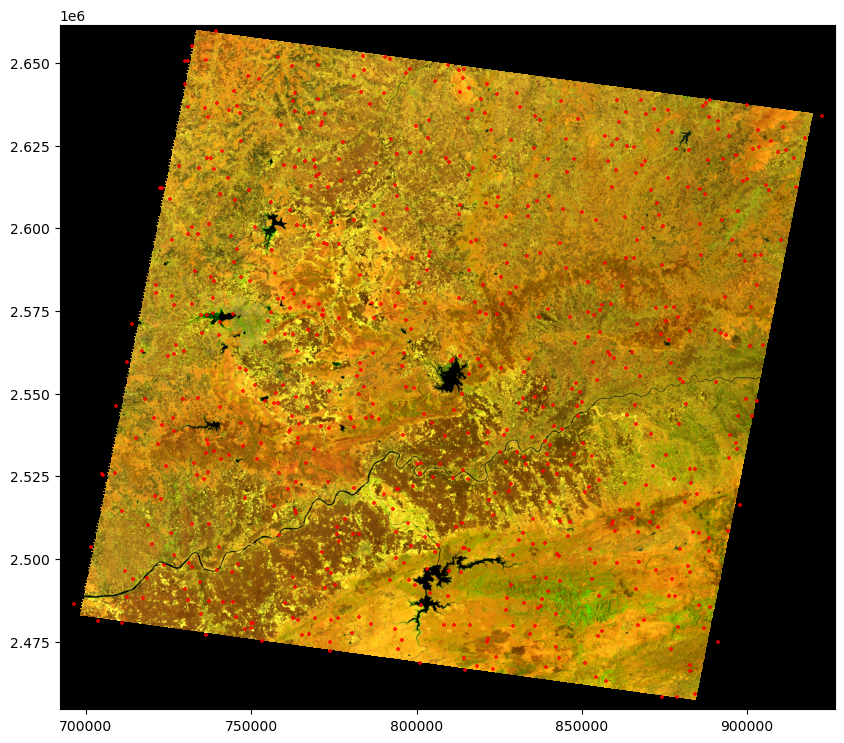

In [7]:
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(figsize = (10,10))

#create the rgb bands
rgb  = np.stack((bands[4], bands[3], bands[2]), axis =0)

# Apply contrast stretching
#get the 2, 98 percentiles for clipping

p2, p98 = np.nanpercentile(rgb, (2, 98))

#clip the values within the range
# every value below 2nd percentile and above 98th percentile will be truncated to the given percentile values

rgb = np.clip(rgb, p2, p98)

#apply the normalisation  (0-1) 
rgb = (rgb - p2) / (p98 - p2)


#plot the image
training_pixels.plot(ax =ax, color = 'red', alpha = .8, markersize = 8, marker = '+')

show(rgb, ax = ax, transform=raster.transform)
plt.show()


## Data Prep

To create our training data, we need to gather the band values for each point in our labelled training samples and raster image. We do this by iterating through the points while traversing the raster and saving the values of each band into an array as rows.

We use the latitude and longitude values from the points as an index to locate the corresponding pixel position and its respective row and column position in our data arrays. Once we have this information, we extract the values for each pixel across all the bands.

If your labeled training samples are not points, but rather polygons or other shapes, you can rasterize them using the `rasterio.rasterize()` function and extract the band values for each polygon. More information on this process can be found in the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/topics/features.html#rasterizing-features).

We also use the label values from each point to add them to the respective label dataset. This ensures that we have the appropriate labels assigned to their corresponding data points.


In [ ]:
band_vals =[] 
labels = []

for index, row in training_pixels.iterrows():
    x = row['geometry'].x
    y = row['geometry'].y
    label = row['land_class']
    
    # get the respective row, col
    row, col = raster.index(x,y)

    #get the data for all bands for that pixel
    data = bands[:, row, col]

    # add it to the X
    band_vals.append(data)
    
    # add the respective label class to y
    labels.append(class_dict[label])

In [34]:
# convert band_vals and labels to full array 

X = np.array(band_vals)

y = np.array(labels)

# check if they have same length
(X.shape, y.shape)


((700, 6), (700,))

We can observe that the our new data has 700 rows and 6 cols. These 6 cols are the bands values for each point
Since we have some training data outside the image, we should remove. This is important since the algorithm won't run with NaN values.

In [35]:


# mask values for the rows with nan
nan_mask = np.any(np.isnan(X), axis =1)

#remove the rows with the mask =TRUE
X = X[~nan_mask]

#apply the same for y
y= y[~nan_mask]

(X.shape, y.shape)

((685, 6), (685,))

## Indices

Indices are mathematical combinations of bands that are used to highlight a specific feature in the image. 

One might ask, why do we need indices if already have those bands in the dataset. Answer is that, indices provide more information and highlight a specific characteristic of a pixel like vegetation,water etc. Thus, providing the algorithm with more patterns leading to improved results.

We add following indices to our dataset:

| Index                                        | Description                                                                                                                   | Landsat 5 Calculation                          |
|----------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------|
| NDVI (Normalised Difference Vegetation Index) | Measure of vegetation and it is calculated as the difference between NIR and Red band. This is helpful since the burned area lacks vegetation. | (Band 4 - Band 3) / (Band 4 + Band 3)          |
| NDWI (Normalised Difference Water Index)      | Measure of water and it is calculated as the difference between NIR and SWIR band. This is helpful since the burned area gets confused with water.      | (Band 5 - Band 3) / (Band 5 - Band 3)          |
| NDMI (Normalised Difference Moisture Index)   | Measure of moisture and it is calculated as the difference between NIR and SWIR band. This is helpful since the burned area lacks moisture.           | (Band 5 - Band 4) / (Band 5 + Band 4)          |
| BAI (Burned Area Index)                       | Measure of burned area and it is calculated as the difference between NIR and SWIR band.                                            | 1.0 / ((0.1 - Band 4)^2 + (0.06 - Band 5)^2)   |
| NBR (Normalised Burned Ratio)                 | Measure of burned area and it is calculated as the difference between NIR and SWIR band.                                            | (Band 4 - Band 7) / (Band 4 + Band 7)          |


We write function that take the arrays and provide an ouput value for each row in an array

In [36]:

# we calculate and use np.expand to add a dimension so that i match with the X which is needed when we add it to the main data

def indice_calc(array_in, band1, band2):
    return np.expand_dims((array_in[:,band1]- array_in[:,band2])/(array_in[:,band1]+ array_in[:,band2]), axis = 1)


ndvi = indice_calc(X,3,2)
ndwi = indice_calc(X,4,2)
ndmi = indice_calc(X, 4,3)
nbr = indice_calc(X, 3,5)

bai = np.expand_dims((1.0 / ((0.1 - X[:,3]) ** 2 + (0.06 - X[:,4]) ** 2)), axis =1)

# add the indices to the X
X = np.concatenate([X, ndvi, ndwi, ndmi, nbr, bai], axis =1)


## Model building

In machine learning models we train on a subset of data and test on the remaining data. We use the train_test_split function from sklearn to split the data into train and test sets. We use 80% of the data for training and 20% for testing. We also use stratify option to make sure that the class distribution is same in both train and test sets.

In [12]:
from sklearn.model_selection import train_test_split

# we split 80:20 for training and test
# we use stratified split based on the class for balances train and test data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state =42, stratify = y)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((548, 11), (137, 11), (548,), (137,))

Since we don't have equal number of samples for each class we create a dictionary that specifies the relative class distribution for our data. This would helps the algorithm to reduce the bias.
We obtain the class weights by calculating the reciprocal of the class counts. These weights will assign higher importance to minority classes during model training, helping to mitigate the effects of class imbalance.

In [14]:
labels, counts = np.unique(y_train, return_counts = True)
class_weight_dict = dict(zip(labels, 1/counts))
class_weight_dict

{0: 0.005, 1: 0.0028735632183908046}

### Train the model

Random Forest is a supervised classification algorithm that uses ensemble learning method for classification. Ensemble learning is a type of learning where you join different types of algorithms or same algorithm multiple times to form a more powerful prediction model. The random forest algorithm combines multiple algorithm of the same type i.e. multiple decision trees, resulting in a forest of trees, hence the name "Random Forest". In general, the more trees in the forest the more robust the forest looks like. In the same way in the random forest classifier, the higher the number of trees in the forest gives the high accuracy results.

It uses decision trees to classify the data into pre-defined classed and then utlise the majority voting to decide the final class. Some of the parameters are:

- Number of Trees : Number of trees in the forest.
- Number of Varibales per Split: Number of variables to consider when looking for the best way to split the data at each node of a decision tree.
- Class Weight: Weights associated with classes. If not given, all classes are supposed to have weight one.

In [15]:
#build the model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    # number of decision trees
    n_estimators=200,
    # class weights
    class_weight= class_weight_dict,
    # n splits per tree
    max_depth=2,
    #paralisation needed or not
    n_jobs = 1,
    #progress indicator
    verbose =1,
    random_state = 42
)

### Fit the model

In [16]:
# fit the model
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(class_weight={0: 0.005, 1: 0.0028735632183908046},
                       max_depth=2, n_estimators=200, n_jobs=1, random_state=42,
                       verbose=1)

### Predict

We predict on test data using predict function and then calculate the accuracy score using accuracy_score function.

In [17]:
preds = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


### Accuracy Assement

We use the confusion matrix to assess the accuracy of the model. The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

There is slight difference in the terms used for accuracy assessment in both remote sensing and machine learning. In remote sensing, we use the terms producer's and user's accuracy. In machine learning, we use the terms precision and recall. They are defined as follows:

- Overall accuracy: The proportion of correctly classified samples out of the total number of samples in the dataset.
- User's accuracy / Precision: The proportion of correctly classified samples for a given class out of the total number of samples predicted to be in that class.
- Producer's accuracy / Recall: The proportion of correctly classified samples for a given class out of the total number of samples that are actually in that class.

We will also use F1 score to assess the accuracy of the model. F1 score is the harmonic mean of precision and recall. It is a good measure of model accuracy for imbalanced datasets. It is calculated as follows:

F1 = 2 * (precision * recall) / (precision + recall)


#### Confusion Matrix




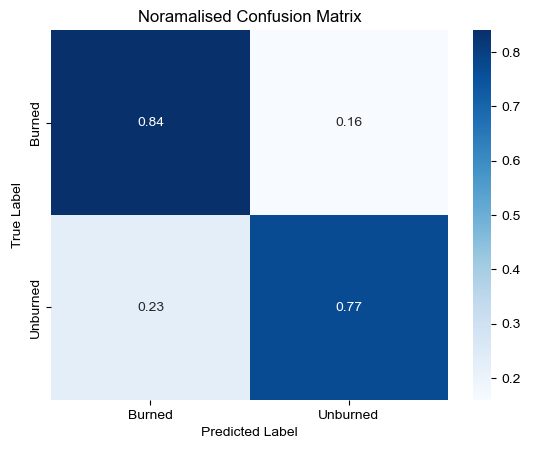

In [18]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

cm = confusion_matrix(y_test, preds)
#normalised cm
cm = cm.astype('float')/cm.sum(axis =1)[:, np.newaxis]

# Plot confusion matrix as heatmap with class labels
ax = sns.heatmap(cm, annot=True, cmap='Blues', 
            xticklabels=class_dict.keys(), 
            yticklabels=class_dict.keys())

ax.set_title('Noramalised Confusion Matrix')
ax.set_xlabel("Predicted Label")
ax.set_ylabel('True Label')


sns.set()


In [19]:
# calculate the overall accuracy
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)

print(f'The overall accuracy is {overall_accuracy:.2f}.')

The overall accuracy is 0.81.


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision for a specific class
class_precision = precision_score(y_test, preds, labels=[0], average=None)
print(f"User's accuracy/Precision for Burned Class : {class_precision[0]:.2f}")

# Calculate recall for a specific class
class_recall = recall_score(y_test, preds, labels=[0], average=None)
print(f"Producer's accuracy/Recall for Burned class: {class_recall[0]:.2f}")

# Calculate F1 score for a specific class
class_f1_score = f1_score(y_test, preds, labels=[0], average=None)
print(f"F1 score for Burned class: {class_f1_score[0]:.2f}")

User's accuracy/Precision for Burned Class : 0.68
Producer's accuracy/Recall for Burned class: 0.84
F1 score for Burned class: 0.75






As we can see from the confusion matrix, the model is able to predict the burned class with 84% accuracy. The model is able to predict the non-burned class with 77% accuracy. The overall accuracy of the model is 81%. But it is important to note that the overall accuracy is not a good measure of model accuracy for imbalanced datasets. Hence, we use F1 score to assess the accuracy of the model. 



## Hyper parameter tuning

Before we finalise our model, we need to find the best parameters for the model.  This is a process of finding the best parameters for the model that gives the best accuracy is called hyper parameter tuning. We use `GridSearchCV` function from sklearn to find the best parameters for our model. We provide a range of values for each parameter and the GridSearchCV function will try all the combinations of the parameters and find the best parameters for our model. We use the best parameters to train our model and then use that to predict all over the image.

GridSearchCV also allows you to cross-validate your parameters. Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. In k-fold cross-validation, you split the input data into k subsets of data (also known as folds). You then iterate over k ML models. In each iteration, you use one of the k subsets as the test set (also called the validation data) and the union of the other subsets as the training set. For example, suppose you have 5000 input samples. You split the data into 5 folds of 1000 samples each. You train the ML model on 4 of the 5 folds (4000 samples) and evaluate it on the remaining 1 fold (1000 samples). You repeat this process 5 times (each time with a different fold as the evaluation dataset) and average the accuracy scores obtained in all the 5 iterations to get a final score for the ML model.

In our case, we use the same parameters as before and provide a range of values for each parameter. We use 5-fold cross-validation to find the best parameters for our model. We use the best parameters to train our model and then use that to predict all over the image.

In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# create a classfier object

clf = RandomForestClassifier(random_state=10, class_weight=class_weight_dict)

# the parameter grid to be tested

param_grid = {
    'n_estimators':list(range(100,500,100)),
    'max_depth': [3,5,7],
    # minimum numbee required to split another internal node
    'min_samples_split': [2,4,6]
}

# perfrom grid-search with cross validation
# we choose f1 score to as the metric to compare score

grid_search = GridSearchCV(clf, param_grid,cv = 5, scoring='f1')
grid_search.fit(X_train, y_train)

# extract the best parameters and best score

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# we create a new clf with best params
final_clf = RandomForestClassifier(random_state=10, class_weight=class_weight_dict, **best_params)

# fit the model with the best params
final_clf.fit(X_train, y_train)


Best Parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.8899791686173177




We can see that the F1 score has improved from 0.86 to 0.87. We can also see that the best parameters for the model are max_depth = 7, min_samples_split = 6 and n_estimators = 100. We use these parameters to train our model and then use that to predict all over the image.

## Predict over the entire image

We have built our model based on the training data from the full image which is a small portion. Now we will use the model to predict the burned area for the entire image. We will use the predict function to predict the burned area for the entire image. 
We are going by small patches to minimise memory use and to avoid crashes. For, that we read our full image and the collect the profile data to write the metadata for  the classified band. We read the bands later by specifying a small patch of the image using window function. Parallel to this we open the image to saved in the write mode and then write onto it window by window.

In [43]:
import datetime

start_time = datetime.datetime.now()

# reading raster windows
# input raster
l5_image  = raster_path

# output file
output_image = './data/l5_ms_pc_classified.tif'

# open the full image using rasterio



with rasterio.open(l5_image, 'r') as src:
    profile = src.profile
    #update profile for the classification ouput
    profile.update(
        # since we have nan
        dtype = rasterio.float32,
        # specify the band n
        count = 1
    )
    # open the output file in write mode
    with rasterio.open(output_image, 'w', **profile) as dst:

        # specify the patch size
        patch_size = 1000
        
        rows = src.shape[0]//patch_size+1
        cols = src.shape[1]//patch_size+1
        #rows = 2
        #cols =2 
        for i in range(rows):
            for j in range(cols):
                window = rasterio.windows.Window(
                    row_off = i * patch_size,
                    col_off = j * patch_size,
                    # adding to ensure this doesn't go out of the image
                    height = min(patch_size, src.shape[0] - i* patch_size),
                    width = min(patch_size, src.shape[1] - j*patch_size)
                )
                #print(f"Current window is {window.row_off, window.col_off}")


                # read the window
                data = src.read(window=window)
                

                # we swap the axis since it get's the masking right
                img_swp = np.moveaxis(data, 0,-1)
                # now we flatten the data to 2-dim array for training
                # -1 will infere the size of first dimension based on second dim, then band size would be used as a the second dim
                img_flat = img_swp.reshape(-1, img_swp.shape[-1]) 
                # let's use indice_cal function to calculte indices

                ndvi = indice_calc(img_flat,3,2)
                ndwi = indice_calc(img_flat,4,2)
                ndmi = indice_calc(img_flat, 4,3)
                nbr = indice_calc(img_flat, 3,5)
                bai = np.expand_dims((1.0 / ((0.1 - img_flat[:,3]) ** 2 + (0.06 - img_flat[:,4]) ** 2)), axis =1)
                # add it to flat data using concat
                img_w_ind = np.concatenate([img_flat,ndvi, ndwi,ndmi, nbr, bai], axis = 1)

                # let's mask the invalid data before training

                mask= np.ma.masked_invalid(img_w_ind)

                # we apply to the data and extract only valid values

                img_masked = img_w_ind[~mask.mask]

                # since it converts the 2d to 1d, we need convert it back again

                to_predict = img_masked.reshape(-1, img_w_ind.shape[-1] )

                # some inputs will be empty especially if you have masked large portions
                # we add a contignecy option to skip that is the case

                if not len(to_predict):
                    continue

                # predict
                # retuns a 1dim array with the predicted classes
                img_pred = final_clf.predict(to_predict)

                # add the data back to the valid pixels using first bands's mask as an index
                # initiate an empty array to store the modified values after masking

                output = np.zeros(img_flat.shape[0])

                output[~mask.mask[:,0]] = img_pred

                # convert to original image dimensions
                # keep in mind that is only 1 band. so we need to give the row,col as an input

                output = output.reshape(*img_swp.shape[:-1])

                # create a final mask for writing
                # so we conver the current mask to image dimensions but only one band
                mask_w = (~mask.mask[:,0].reshape(*img_swp.shape[:-1]))

                #write final files

            

                dst.write(output.astype(rasterio.uint8),1, window = window)

                dst.write_mask(mask_w, window = window)

end_time= datetime.datetime.now()
print(f"Process finished. Time taken: {end_time-start_time}")

        



Process finished. Time taken: 0:03:58.447337


### Visualise the results

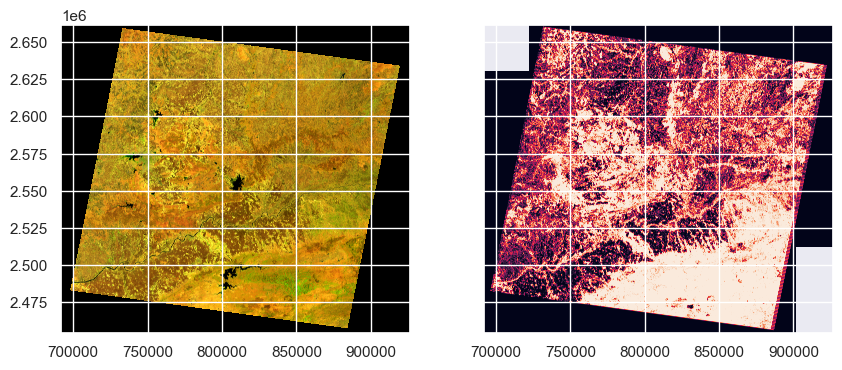

In [44]:
## visualise the image

import matplotlib.pyplot as plt
from rasterio.plot import show
fig,(ax1, ax2) = plt.subplots(ncols =2, nrows= 1,figsize = (10,4), sharey=True)


# read the classified image
with rasterio.open('./data/l5_ms_pc_classified.tif', 'r') as output_raster:
    #show(output_raster)
    classes = output_raster.read()

show(rgb, transform=raster.transform, ax = ax1)
show(classes, transform= output_raster.transform, ax = ax2)
plt.show()


We can see that all the red areas are fire instances. Let's quantify the percentage of area burned in the image.


### Quantify burned area

In [45]:
# we use the classes variable to compute

# count the number of pixels with 0 value excluding NaN
class_0_count = np.count_nonzero(classes == 0)
class_0_count

#total pixels
total_pixels = np.count_nonzero(~np.isnan(classes))
total_pixels

class_0_pc = (class_0_count/total_pixels)*100

print(f"total area of burned area in this image is: {class_0_pc:.2f}%")

# calculate in km2
width_km = 170
height_km = 183
l5_area_km2 = width_km * height_km
l5_burned_area = l5_area_km2*(class_0_pc/100)

print(f"total area of burned area in this image is: {l5_burned_area:.2f} KMsq")



total area of burned area in this image is: 52.74%
total area of burned area in this image is: 16407.51 KMsq



We can observe that half the image area is burned and that is around ~ 16000 Kilometer Square Area. 





## Conclusion

We have successfully built a model and use it to predict over the image. This shows that we can use machine learning to predict fire over large areas. We can use this model to predict fire over large areas and then use that information to take preventive measures.

There are many ways to improve the model. We can use more samples for burned class to improve the accuracy of the model. We can also use other algorithms like Support Vector Machine to improve the accuracy of the model. We can also use other informaton like slope, aspect, elevation, etc. to improve the accuracy of the model. I have limited the scope of this tutorial to Random Forest Classifier with limited data. But, you can try other algorithms and see if you can improve the accuracy of the model.


You can find the full notbeook and the data in this github repository: [Link](https://github.com/AbdulNajah/burned-area-prediction-landsat5)

Note: Feel free to ask any questions if you need further clarification or have doubts!